In [1]:
%pylab inline
import tensorflow as tf
import os

PATH = '/content/drive/MyDrive/Proyecto_Laboratorio_Avanzado_II'
INPATH_REAL = PATH + '/hdata_set_R'
INPATH_IMG = PATH + '/hdata_set_C'
OUPATH = PATH + '/data_set'

imgurls = !ls -1 '/content/drive/MyDrive/Proyecto_Laboratorio_Avanzado_II/hdata_set_R'

n = 100
train_n = round(n*0.8)
tr_urls = imgurls[:train_n]
ts_urls = imgurls[train_n:n]

Populating the interactive namespace from numpy and matplotlib


### Si hay relación entre $\mathcal{Re}$ y $\mathcal{Im}$, entonces la reconstrucción podría ser factible con una sola parte.

In [2]:
@tf.function()
def load_image(filename):
  inimgRe = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH_REAL+'/'+filename)), tf.float32)[...,:1]
  inimgIm = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH_IMG+'/'+filename)), tf.float32)[...,:1]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH+'/'+filename)), tf.float32)[...,:1]

  #hologram = inimgRe+1j*inimgIm
  hologram = tf.complex(inimgRe, inimgIm)
  #hologram=hologram*np.conj(hologram)
  hologram = tf.math.multiply(hologram, tf.math.conj(hologram))
  hologram=tf.math.abs(hologram)

  return hologram, tgimg

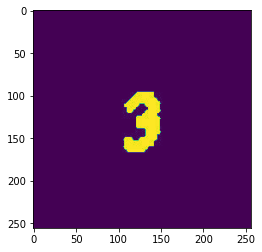

In [3]:
plt.imshow(np.squeeze(load_image(imgurls[0])[1]))

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)

train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.batch(1)
test_dataset = test_dataset.batch(1)

In [18]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [19]:
def Downsample(numFilters, apply_batchnorm = True):
  """
  Esta función constituye un bloque del encoder de tres capas consecutivas Conv-BatchNorm-Activ y que se reutilizará constantemente.
  """
  result = tf.keras.models.Sequential()
  initializer = tf.random_normal_initializer(0, 0.02)

  #Capa convolucional.
  result.add(tf.keras.layers.Conv2D(numFilters,
                                    kernel_size=4,
                                    strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias= not apply_batchnorm))

  if apply_batchnorm:
    #Capa batchnorm.
    result.add(tf.keras.layers.BatchNormalization())

  #Capa activación.
  result.add(tf.keras.layers.LeakyReLU())

  return result

In [20]:
Downsample(64)

In [21]:
def Upsample(numFilters, apply_dropout = False):
  """
  Esta función constituye un bloque del decoder de tres capas consecutivas Conv-DropOut-Activ y que se reutilizará constantemente.
  """
  result = tf.keras.models.Sequential()
  initializer = tf.random_normal_initializer(0, 0.02)

  #Capa convolucional.
  result.add(tf.keras.layers.Conv2DTranspose(numFilters,
                                             kernel_size=4,
                                             strides=2,
                                             padding='same',
                                             kernel_initializer=initializer,
                                             use_bias= False))
  
  #Capa batchnorm.
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    #Capa dropout.
    result.add(tf.keras.layers.Dropout(0.5))

  #Capa activación.
  result.add(tf.keras.layers.ReLU())

  return result

In [29]:
#from typing_extensions import Concatenate
def Generator():
  #Para imágenes de diferentes tamaños: input_shape=(None, None, 1).
  inputs = tf.keras.layers.Input(shape=[256, 256, 1])

  #Contruimos el stack de bloques (sin conectarlos).
  down_stack = [
      Downsample(64, apply_batchnorm=False), #(bs, 128, 128, 64)
      Downsample(128),                       #(bs, 64, 64, 128)
      Downsample(256),                       #(bs, 32, 32, 256)
      Downsample(512),                       #(bs, 16, 16, 512)
      Downsample(512),                       #(bs, 8, 8, 512)
      Downsample(512),                       #(bs, 4, 4, 512)
      Downsample(512),                       #(bs, 2, 2, 512)
      Downsample(512)                        #(bs, 1, 1, 512)
  ]

  up_stack = [
      Upsample(512, apply_dropout=True),     #(bs, 2, 2, 512)
      Upsample(512, apply_dropout=True),     #(bs, 4, 4, 512)
      Upsample(512, apply_dropout=True),     #(bs, 8, 8, 512)
      Upsample(512),                         #(bs, 16, 16, 512)
      Upsample(256),                         #(bs, 32, 32, 256)
      Upsample(128),                         #(bs, 64, 64, 128)
      Upsample(64)                           #(bs, 128, 128, 64)
  ]

  initializer = tf.random_normal_initializer(0, 0.02)

  #Última capa, imagen reconstruida.
  last = tf.keras.layers.Conv2DTranspose(filters=1,
                                        kernel_size=4,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        activation = 'sigmoid')

  
  x = inputs
  #Para conexión enc-dec.
  skip = []
  concat = tf.keras.layers.Concatenate()
  
  #Conexión entre capas encoder.
  for down in down_stack:
    x = down(x)
    skip.append(x)

  skip = reversed(skip[:-1])
  #Conexión entre capas decoder.
  for up, sk in zip(up_stack, skip):
    x = up(x)
    #En U-Net se necesitan skip-connections.
    x = concat([x, sk])

  last = last(x)
  return tf.keras.Model(inputs=inputs, outputs=last)

#bs: batch_size.

In [33]:
def Generator2():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    Downsample(64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    Downsample(128),  # (batch_size, 64, 64, 128)
    Downsample(256),  # (batch_size, 32, 32, 256)
    Downsample(512),  # (batch_size, 16, 16, 512)
    Downsample(512),  # (batch_size, 8, 8, 512)
    Downsample(512),  # (batch_size, 4, 4, 512)
    Downsample(512),  # (batch_size, 2, 2, 512)
    Downsample(512),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    Upsample(512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    Upsample(512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    Upsample(512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    Upsample(512),  # (batch_size, 16, 16, 1024)
    Upsample(256),  # (batch_size, 32, 32, 512)
    Upsample(128),  # (batch_size, 64, 64, 256)
    Upsample(64),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [34]:
from tensorflow.python import training
generator = Generator2()
#generator.summary()
#genOut = generator(load_image(imgurls[0])[0], training =False)

In [ ]:
!pip install plot_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


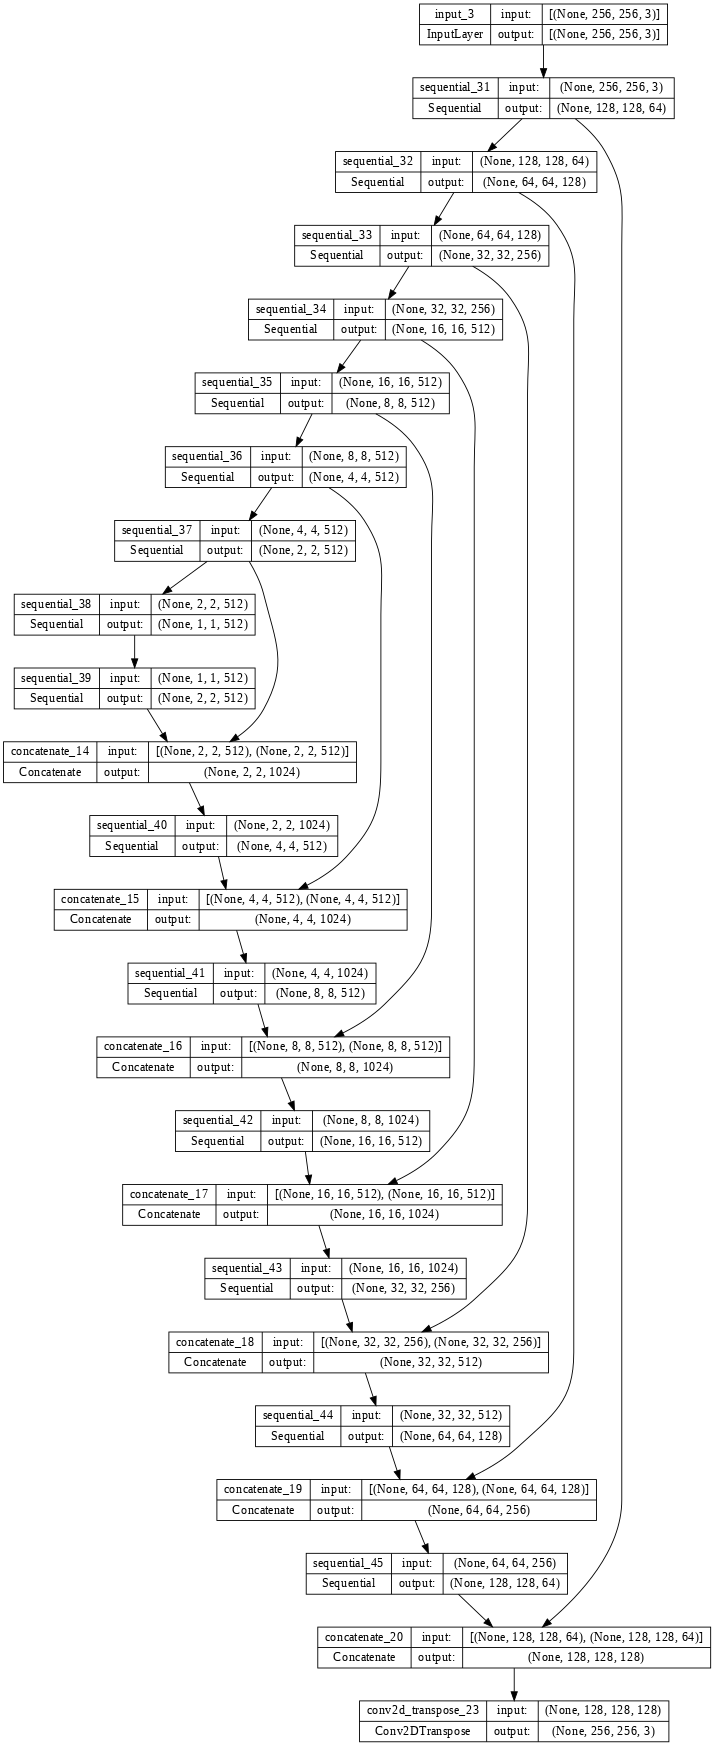

In [35]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [26]:
load_image(imgurls[0])[0]
genOut = generator(load_image(imgurls[0])[0], training =False)
#plt.imshow(np.squeeze(genOut[0,...]))

InvalidArgumentError: ignored

In [ ]:
def Discriminator():
  """
  Discriminador por parches.
  """
  #Le vamos a pasar la imagen original(holograma) y la imagen de salida del generador(reconstrucción).
  initial = tf.keras.layers.Input(shape=[256, 256, 1], name='Input_img')
  gen = tf.keras.layers.Input(shape=[256, 256, 1], name='Gener_img')

  #Poniendo una imagen encima de la otra.
  concat = tf.keras.layers.Concatenate()
  stack = concat([initial, gen])

  #Capas del modelo.
  initializer = tf.random_normal_initializer(0, 0.02)
  down1 = Downsample(64, apply_batchnorm=False)(stack)
  down2 = Downsample(128)(down1)
  down3 = Downsample(256)(down2)
  down4 = Downsample(512)(down3)

  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding='same')(down4)
                        
  return tf.keras.Model(inputs=[initial, gen], outputs=last)

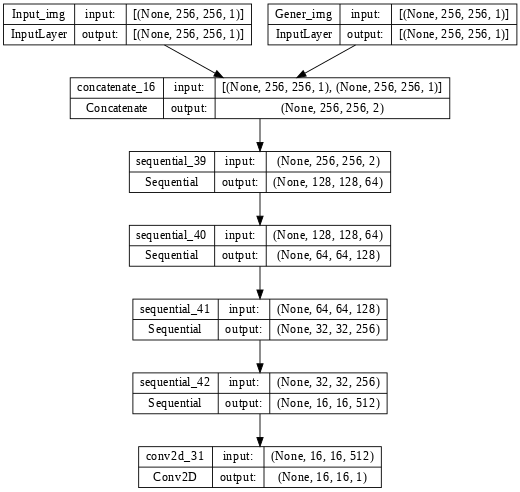

In [ ]:
dicriminator = Discriminator()
tf.keras.utils.plot_model(dicriminator, show_shapes=True, dpi=64)

In [ ]:
#Dar más peso al error L12 que al adversario.
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discrimitator_loss(disc_real_output, disc_generated_output):
  #Evaluando la función de pérdida con un resultado de todo real.
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  #Evaluando la función de pérdida con un resultado de todo falso.
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_loss = real_loss + generated_loss

  return total_loss

def generator_loss(disc_generated_output, gen_output, target):

  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss 

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
from tensorflow.python.eager.backprop import GradientTape

@tf.function()
def train_step(input_image, target):

  with GradientTape() as gen_tape, GradientTape() as discr_tape:

    output_image = Generator(input_image, training=True)
    output_gen_discr = Discriminator([output_image, input_image], training = True)
    output_trg_discr = Discriminator([target, input_image], training = True)
    discr_loss = discrimitator_loss(output_trg_discr, output_gen_discr)
    gen_loss = generator_loss(output_gen_discr, output_image, target)

    generator_grads = gen_tape.gradient(gen_loss, Generator.trainable_variables)
    discriminator_grads = discr_tape.gradient(discr_loss, Discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, Generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, Discriminator.trainable_variables))

In [ ]:
from IPython.core.display import clear_output
def Train(dataset, epochs):
  for epoch in range(epochs):
    imgi = 0

    for input_image, target in dataset:
      print('epoch: {}- train: {}/{} '.format(epoch, imgi, len(tr_urls)))
      imgi+=1
      train_step(input_image, target)
    
    clear_output(wait=True)
    for inp, tar in test_dataset.take(5):
      generate_images(Generator, inp, tar, str(imgi)+'_'+str(epoch), display_imgs=True)

## Prueba tres canales.

(256, 512, 3)


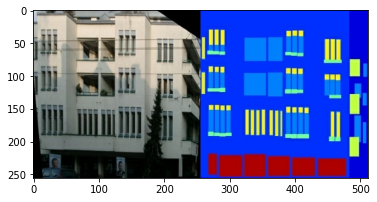

In [12]:
import pathlib
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name
list(PATH.parent.iterdir())
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)
plt.figure()
plt.imshow(sample_image)

def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

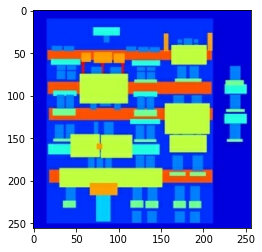

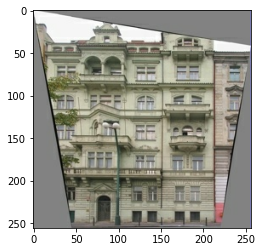

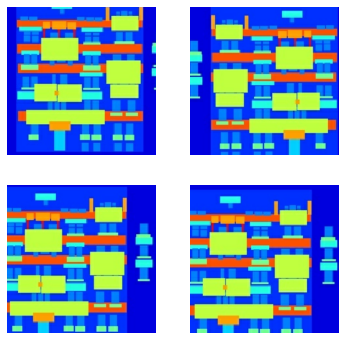

In [13]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [15]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

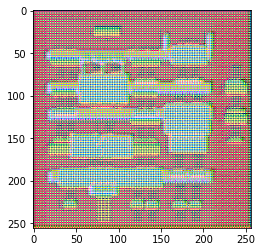

In [36]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [37]:
inp[tf.newaxis, ...]

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[  7.,   6., 172.],
         [  0.,   0., 222.],
         [  0.,   0., 222.],
         ...,
         [  0.,   0., 222.],
         [  0.,   0., 222.],
         [  0.,   0., 222.]],

        [[  7.,   6., 172.],
         [  0.,   0., 222.],
         [  0.,   0., 222.],
         ...,
         [  0.,   0., 222.],
         [  0.,   0., 222.],
         [  0.,   0., 222.]],

        [[  7.,   6., 172.],
         [  0.,   0., 222.],
         [  0.,   0., 222.],
         ...,
         [  0.,   0., 222.],
         [  0.,   0., 222.],
         [  0.,   0., 222.]],

        ...,

        [[  7.,   6., 172.],
         [  0.,   0., 222.],
         [  0.,   0., 222.],
         ...,
         [  0.,   0., 222.],
         [  0.,   0., 222.],
         [  0.,   0., 222.]],

        [[  7.,   6., 172.],
         [  0.,   0., 222.],
         [  0.,   0., 222.],
         ...,
         [  0.,   0., 222.],
         [  0.,   0., 222.],
         